## CLUSTERING VALIDATION PROTOCOL (see Supp. Info.)

In [46]:
%pylab inline
%config InlineBackend.figure_format='svg'
import sympy
import sys
import random
import math
import scipy
import os
import time

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering as AgCl
from sklearn.cluster.hierarchical import ward_tree 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [47]:
# file where S3D results (epsilon, eigenvectors, eigenvalues) are stored
filename = './fip35_example.npz'

### hard code how distances are computed as merging of clusters occurs

Lance - Williams formula to compute distances between merging clusters (see Wiki @ Ward's method)
$$d\left(\mathcal{C}_i \cup \mathcal{C}_j, \mathcal{C_k} \right) = \frac{n_i + n_k}{n_i + n_j + n_k} d\left(\mathcal{C}_i , \mathcal{C}_k \right) + \frac{n_j + n_k}{n_i + n_j + n_k} d\left(\mathcal{C}_j , \mathcal{C}_k \right) - \frac{n_k}{n_i + n_j + n_k} d\left(\mathcal{C}_i , \mathcal{C}_j \right)$$

In [48]:
def clust_dist(idx_a, na, idx_b, nb, idx_v, nv, dX):
    
    """
    Lance Williams implementation for computing the distance between cluster idx_v and the new cluster
    obtained from merging clusters idx_a and idx_b
    
    INPUT:
        * idx_a, idx_b, idx_v (int), cluster indices
        * na, nb, nv (int), number of elements in cluster a-th, b-th and v-th respectively
        * dX (array of floats), matrix of cluster- - cluster distances BEFORE merging
        
    OUTPUT:
        * dist (float), distance between cluster v-th and the new cluster obtained by merging clusters
                        a-th and b-th
    """
    
    
    T = float(na + nb + nv)
    dist = (float(na+nv)/T)*dX[idx_a,idx_v]**2 + (float(nb+nv)/T)*dX[idx_b,idx_v]**2 - \
           (float(nv)/T)*dX[idx_a,idx_b]**2
    
    return np.sqrt(dist)

### hard code agglomerative clustering with Ward distance, extract silhouette score

In [49]:
def clustering_ward_metric(X):
    
    """
    Compute silhouette score for each cluster, for all agglomerative clustering iterations
    
    INPUT:
        * X (array of floats, (m, n)), n clustering coordinates for a m-th dimensional set
        
    OUTPUT:
        * s ((m-1) dimensional list of (m-1), (m-2).... dimensional arrays
            s[i][j] is the silhouette score for the j-th cluster @ i-th iteration
    """
    
    tol = 1e-12

    # build ward_tree out of distance matrix X
    tree_ward = ward_tree(X, return_distance=True)

    card_all = []
    cluster_indexes_all = []
    dX_min = []
    dA_all = []
    dX_all = []
    silhouette = []
    
    
    print('zeroth step: each datum is a cluster, and distances are Euclidean in clustering coord space...')
    
    cluster_indexes = np.arange(np.shape(X)[0]).astype(int)
   
    card = np.zeros(2*np.shape(X)[0]).astype(int)

    card[cluster_indexes] = 1
    
    cluster_indexes_all.append(cluster_indexes)
    card_all.append(card)
    
    dA0 = np.zeros(np.shape(cluster_indexes)[0])
    dX0 = np.zeros((2*np.shape(cluster_indexes)[0], 2*np.shape(cluster_indexes)[0]))
    
    # initialization: each datum is a cluster, compute all distances as they are
    
    for i in range(np.shape(cluster_indexes)[0]-1):
        for j in range(i+1,np.shape(cluster_indexes)[0]):
            dX0[i,j] = np.sqrt(np.sum((X[i,:]-X[j,:])**2))
            dX0[j,i] = dX0[i,j]

    dX_all.append(dX0)
    dA_all.append(dA0)
    
    dA_old = dA0
    cluster_indexes_old = cluster_indexes
    
    dX0_min = np.zeros(np.shape(cluster_indexes)[0])
    for j, idx in enumerate(cluster_indexes):
        other_indexes = list(set(cluster_indexes) - set([idx]))    # all indices but current
        dX0_min[j] = np.min(dX0[idx,other_indexes])
    dX_min.append(dX0_min)        # minimal distance, to be used in calculation of silhouette score
    
    #print(np.min(dX0_min), tree_ward[4][0])
    #print(np.min(dA0))
    
    s = np.zeros(len(cluster_indexes))
    
    for j in range(len(cluster_indexes)): 
        ABmax = max(dA0[j],dX0_min[j])
        s[j] = (dX0_min[j] - dA0[j] )/ABmax 
            
    silhouette.append(s)
    
    print('Start clustering iterations: each iteration corresponds to a merging of a ONE pair of clusters')
    print('The pair is removed from cluster list, and the new cluster is added...overall each iteration' \
         'decreases the number of clusters by a unit')
    
    for k in range(tree_ward[2]-2):
    
        new_idx = tree_ward[2]+k         # a new cluster is formed by merging clusters idx_1 and idx_2
        idx_1 = tree_ward[0][k][0]       # this new cluster is identified by a 'new_idx' index
        idx_2= tree_ward[0][k][1]
    
        card[new_idx] = card[idx_1] + card[idx_2]
        joined_clusters = set(tree_ward[0][k])
        cluster_indexes = list(set(cluster_indexes) - joined_clusters) 
        
        dX = dX0
        
        # compute manually distances between new cluster and all others (which were left untouched in the
        # current iteration)
        
        for idx in list(cluster_indexes): 
            dX[new_idx, idx] = clust_dist(idx_1, card[idx_1], idx_2, card[idx_2], idx, card[idx], dX0)
            dX[idx, new_idx] = dX[new_idx, idx]
        
        #print(idx_1, idx_2, dX0[idx_1,idx_2])
        dX0_tmp = dX0[idx_1,idx_2]
        
        # set all distances with the old clusters idx_1 and idx_2 (which don't exist anymore, were merged
        # together into a new cluster)
        dX[:, idx_2] = 0.
        dX[:, idx_1] = 0.
        dX[idx_1, :] = 0.
        dX[idx_2, :] = 0.
    
        dX_all.append(dX)
        
        if abs(np.min(dX[np.where(dX > 0.)]) - tree_ward[4][k+1]) > tol:
            print(np.min(dX[np.where(dX > 0.)]))  
            print(np.where(dX == np.min(dX[np.where(dX > 0.)]))) 
            print(tree_ward[4][k+1])
        
        assert abs(np.min(dX[np.where(dX > 0.)]) - tree_ward[4][k+1]) < tol

        if abs(np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]) - tree_ward[4][k+1]) > tol:
            print(np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]))  
            print(np.where(dX_all[k+1] == np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]))) 
            print(tree_ward[4][k+1])
    
        assert abs(np.min(dX_all[k+1][np.where(dX_all[k+1] > 0.)]) - tree_ward[4][k+1]) < tol
    
        # add new index to list
        cluster_indexes = list(cluster_indexes) + [tree_ward[2]+k]
    
        cluster_indexes_all.append(cluster_indexes)
        card_all.append(card)
        
        # cluster assignment
        dA = np.zeros(np.shape(cluster_indexes)[0])
        for j, idx in enumerate(cluster_indexes_old):
            kdx = np.where(np.array(cluster_indexes) == idx)[0]
            dA[kdx] = dA_old[j]
            
        jdx = np.where(np.array(cluster_indexes) == new_idx)[0]
        dA[jdx] = dX0_tmp
        dA_all.append(dA)
        
        dX0 = dX
        
        # compute quantities for silhouette score calculation
        
        dX0_min = np.zeros(np.shape(cluster_indexes)[0])
        for j, idx in enumerate(cluster_indexes):
            other_indexes = list(set(cluster_indexes) - set([idx]))
            dX0_min[j] = np.min(dX[idx,other_indexes])
        dX_min.append(dX0_min)
        
        # compute silhouette scores
        
        s = np.zeros(len(cluster_indexes))
        
        for j in range(len(cluster_indexes)): 
            ABmax = max(dA[j], dX0_min[j])
            s[j] = (dX0_min[j] - dA[j] )/ABmax
            
        silhouette.append(s)
        dA_old = dA
        cluster_indexes_old = cluster_indexes

    return silhouette

In [50]:
def plot_results(filename, neigen, idx_max_eps, nmax, Median = True, Mean = False, Min = False):
    """
    filename (str):               file containing SpaceTime Diffusion Map eigenvalues/eigenvectors
    neigen   (int):               number of eigenvectors used for clustering (double check)
    idx_max_eps (int):            how many different values of epsilon to be considered
    nmax      (int):              maxinmum number of clusters/eigenvalues to consider
     
    """
    
    import matplotlib.gridspec as gridspec
    
    fig = figure(figsize=(6,12))
    colrs = ['purple','blue', 'green', 'red', 'orange', 'yellow']
    
    # define grid space for each plot
    G = gridspec.GridSpec(16, 1)
    ax1 = subplot(G[ :5, :])
    ax2 = subplot(G[6:11, :])
    ax3 = subplot(G[11: , :])
    
    # load Space Time Diffusion Map results
    npzfile = np.load(filename)

    eigenvectors = npzfile['eigenvectors']
    epsilon = npzfile['epsilon']
    eigenvalues = npzfile['eigenvalues']
    

    # define 'timescale like' eigenvalues ('lag' time over eigenvalue log)
    ll = np.zeros(np.shape(eigenvalues))

    neigen_max = np.zeros(np.shape(eigenvalues)[0]).astype(int)
    for i in range(np.shape(epsilon)[0]):
        ll[i,:] = -epsilon[i]/log(real(eigenvalues[i,:]))
    
        nn = np.where(ll[i,:] > epsilon[i])[0]
        neigen_max[i] = np.shape(nn)[0]
    
    # looping over different values of epsilon, using the index of eps_list list
    # iteratively, three plots are going to be built
    
    for j in range(idx_max_eps):
        
        eps_idx = j
    
        # extract those eigenvectors for clustering    
        X = real(eigenvectors[eps_idx,:,1:neigen])       # n_eigen is the number of eigenvectors to consider
                                                         # considering (n_eigen - 1) non trivial eigvects
        
        # computing silouette score for all clusters, in each iteration of agglomerative clustering
        Q = clustering_ward_metric(X)
        
        # use python function to get the Ward distances tree
        tree_ward = ward_tree(X, return_distance=True)   
        
        # compute mean and mean silhouette score
        score = []
        score1 = []
        score2 = []
        for sil in Q:
            score.append(np.median(np.array(sil))) 
            score1.append(np.mean(np.array(sil))) 
            score2.append(np.min(np.array(sil)))
            
        score.append(-1.)
        score1.append(-1.)
        score2.append(-1.)
        
        # ---------------------------------------
        # PLOTTING RESULTS
        # ----------------------------------------
        
            # -------------------------------
            # plot 'normalized' eigenvalues a la' TICA (like timescales)
        
        ax1.scatter(np.arange(np.shape(ll[j,1:])[0])+1, ll[j,1:], color = colrs[j])
        ax1.plot(np.arange(0,nmax+1,1)*0.+neigen-0.5, np.arange(0,nmax+1,1), \
                linestyle = '--', color ='red', linewidth=2)
    
        ax1.axis((0.,nmax, np.min(ll[:,1:])*0.01, np.max(ll[:,1:])*1.2))
        
        major_xticks = np.arange(0, nmax+1, 1)
        ax1.set_xticks(major_xticks)
        ax1.tick_params(labelsize=12)
        ax1.set_ylabel('$-\epsilon/\ln{\, \lambda_i}$', size=18)
        ax1.set_xlabel('Eigenvalue number, i', size=15)
    
        ax1.annotate('# non-trivial eigenvectors used = '+str(neigen-1), \
                    xy=(0.5, 1.05), xycoords='axes fraction', \
                    horizontalalignment='center', verticalalignment='center', \
                    fontsize = 15, color = 'crimson')
        ax1.annotate('$\epsilon$ = '+str(epsilon[j]), xy=(0.45, 0.7-j*0.09), \
                    xycoords='axes fraction', horizontalalignment='left', \
                    verticalalignment='center', fontsize = 18, color = colrs[j])
    
        for idx in range(nmax):       # plot light grey vertical lines @ integers as guide to the eye
            ax1.plot(np.arange(0,nmax+1,1)*0.+idx, np.arange(0,nmax+1,1), \
                    color = 'gray', linewidth=0.1, linestyle ='--')
    
        print('epsilon = ' +str(epsilon[eps_idx]))
        print('eigenvectors below the treshold = ' +str(neigen_max[eps_idx]))

            #------------------------------------
            # plot Ward distance (associated with cluster merging) as a function of the cluster number 
            # (i.e. as a function of the iteration) and for differnt
            # epsilon values, which are also annotated as a reference.
            
            # it might be useful to look at the dendrogram to compare 'Ward distances', it is
            # visually more appealing and intuitive (see below)
        
        ax2.scatter(np.shape(tree_ward[4])[0] - np.arange(np.shape(tree_ward[4])[0]), tree_ward[4], \
                   linewidth = 0, color= colrs[j], s = 50, label = '$\epsilon = '+str(epsilon[j]))
    
        # plot grids as guide to the eye
        for idx in range(nmax):
            ax2.plot(np.arange(0,nmax+1,1)*0.+idx, np.arange(0,nmax+1,1), \
                    color = 'gray', linewidth=0.1, linestyle ='--')

        ax2.plot(np.arange(0,nmax+1,1)*0.+neigen-0.5, np.arange(0,nmax+1,1), \
                linestyle = '--', color ='red', linewidth=2)
    
        ymax = np.max(tree_ward[4])*1.1
        ax2.axis((0.,nmax,0.,ymax))
        ax2.tick_params(labelsize=12, labelbottom='off')
        ax2.set_ylabel('Distance treshold',size=15)

 
            #-----------------------------
            # plotting silohouette score in a format which is input by the user in the plotting function
        
        if Median:
            ax3.scatter(range(1,len(score)+1), score[::-1], s = 50, color = colrs[j], marker = 'o')
            ax3.plot(range(1,len(score)+1), score[::-1], color ='black', linewidth=0.9)
            print('max silhouette score for # clusters = '\
                  +str(np.argmax(score[::-1][:nmax])+1)+' ('+str(np.max(score[::-1][:nmax]))+')')
    
        if Mean:
            ax3.scatter(range(1,len(score1)+1), score1[::-1], s = 50, color = colrs[j], marker=(5, 2))
            ax3.plot(range(1,len(score1)+1), score1[::-1], color = 'gray', linewidth=0.9)
            print('max silhouette score for # clusters = '\
                  +str(np.argmax(score1[::-1][:nmax])+1)+' ('+str(np.max(score1[::-1][:nmax]))+')')
            
        if Min:
            ax3.scatter(range(1,len(score2)+1), score2[::-1], s = 50, color = colrs[j], marker=(5, 2))
            ax3.plot(range(1,len(score2)+1), score2[::-1], color = 'gray', linewidth=0.9)
            print('max silhouette score for # clusters = '\
                  +str(np.argmax(score2[::-1][:nmax])+1)+' ('+str(np.max(score2[::-1][:nmax]))+')')
            
        if (Mean & Median):
            ax3.scatter([0.42*nmax], [0.9-j*0.09], s = 50, color = colrs[j], marker='o')
            ax3.annotate('Median score', xy=(0.45, 0.9-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
            ax3.scatter([0.42*nmax], [0.35-j*0.09], s = 50, color = colrs[j], marker=(5, 2))
            ax3.annotate('Mean score', xy=(0.45, 0.35-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
        if (Median & Min):
            ax3.scatter([1.02*nmax], [0.9-j*0.09], s = 50, color = colrs[j], marker='o')
            ax3.annotate('Median score', xy=(1.05, 0.9-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
            ax3.scatter([1.02*nmax], [0.35-j*0.09], s = 50, color = colrs[j], marker=(5, 2))
            ax3.annotate('Min score', xy=(1.05, 0.35-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
            
        if (Mean & Min):
            ax3.scatter([1.02*nmax], [0.9-j*0.09], s = 50, color = colrs[j], marker='o')
            ax3.annotate('Mean score', xy=(1.05, 0.9-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
            ax3.scatter([1.02*nmax], [0.35-j*0.09], s = 50, color = colrs[j], marker=(5, 2))
            ax3.annotate('Min score', xy=(1.05, 0.35-j*0.09), xycoords='axes fraction', \
                        horizontalalignment='left', verticalalignment='center', \
                        fontsize = 18, color = colrs[j])
    
        for idx in range(nmax):
            ax3.plot(np.arange(0,nmax+1,1)*0.+idx, np.arange(0,nmax+1,1), \
                    color = 'gray', linewidth=0.1, linestyle ='--')
        
        ax3.plot(np.arange(0,nmax+1,1)*0.+neigen-0.5, np.arange(0,nmax+1,1), \
                linestyle = '--', color ='red', linewidth=2)
    
        major_xticks = np.arange(0, nmax+1, 1)
        ax3.set_xticks(major_xticks)
        ax3.tick_params(labelsize=12)
        ax3.set_xlabel('Number of clusters', size=15)
        ax3.set_ylabel('Silhouette score', size=15)
        ax3.axis((0.,nmax,0.,0.99))

    fig.subplots_adjust(wspace=0, hspace=0)
    
    return

### summary plots for each state

zeroth step: each datum is a cluster, and distances are Euclidean in clustering coord space...
Start clustering iterations: each iteration corresponds to a merging of a ONE pair of clusters
The pair is removed from cluster list, and the new cluster is added...overall each iterationdecreases the number of clusters by a unit
epsilon = 0.4
eigenvectors below the treshold = 3
max silhouette score for # clusters = 8 (0.652193351638)
zeroth step: each datum is a cluster, and distances are Euclidean in clustering coord space...
Start clustering iterations: each iteration corresponds to a merging of a ONE pair of clusters
The pair is removed from cluster list, and the new cluster is added...overall each iterationdecreases the number of clusters by a unit
epsilon = 0.6
eigenvectors below the treshold = 2
max silhouette score for # clusters = 8 (0.723582340838)
zeroth step: each datum is a cluster, and distances are Euclidean in clustering coord space...
Start clustering iterations: each iterati

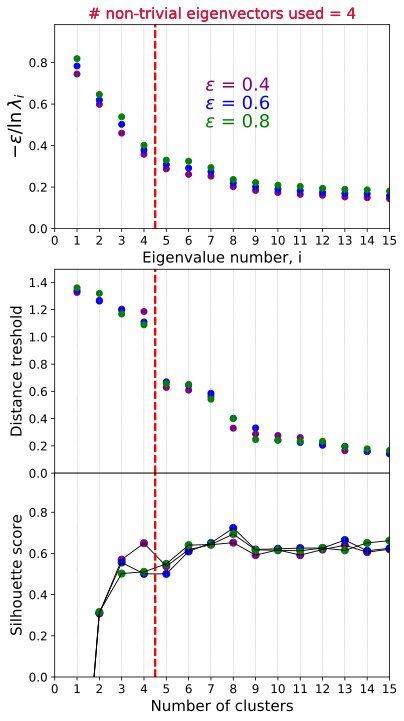

In [51]:
neigen = 5

plot_results(filename, neigen, 3, 15, Median = True, Mean = False, Min = False)
#savefig(filename[:-7]+'ClusteringResults_'+str(neigen-1)+'eigen.png', bbox_inches='tight')

### plot dendrogram associated with Ward clustering

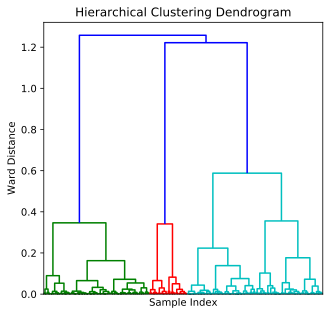

In [52]:
figure(figsize=(5, 5))

npzfile = np.load(filename)
eigenvectors = npzfile['eigenvectors']
epsilon = npzfile['epsilon']
eigenvalues = npzfile['eigenvalues']

neigen = 3
n_eps = 2
X = real(eigenvectors[n_eps,:,1:neigen])

Z = linkage(X, 'ward')

# plot dendrogram
title('Hierarchical Clustering Dendrogram')
xlabel('Sample Index')
ylabel('Ward Distance')
xxx = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels = True)